In [41]:
import os, re, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [42]:
plt.rcParams['figure.dpi'] = 120
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [44]:
DATA_PATH = 'fake_job_postings.csv'
OUTDIR = 'outputs'
os.makedirs(OUTDIR, exist_ok=True)

In [47]:
print("Loading:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Loading: fake_job_postings.csv
Shape: (17880, 18)
Columns: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']


In [49]:
if 'fraudulent' in df.columns:
    label_col = 'fraudulent'
else:
    label_col = None
    for c in df.columns:
        vals = df[c].dropna().unique()
        if set(vals).issubset({0,1}) and len(vals)>1:
            label_col = c
            break
if label_col is None:
    raise ValueError('No 0/1 label column found (expected "fraudulent").')
print("Using label:", label_col)
print(df[label_col].value_counts())

Using label: fraudulent
fraudulent
0    17014
1      866
Name: count, dtype: int64


In [50]:
prefer_text_cols = ['title','job_title','description','requirements','company_profile','benefits']
text_cols = [c for c in prefer_text_cols if c in df.columns]
if not text_cols:
    text_cols = [c for c in df.columns if df[c].dtype=='object'][:3]
print("Text columns used:", text_cols)

def clean_text(s):
    if pd.isna(s): return ""
    s = str(s)
    s = html.unescape(s)
    s = re.sub(r'<[^>]+>',' ', s)
    s = re.sub(r'\s+',' ', s).strip()
    return s

df['text'] = df[text_cols].astype(str).agg(' '.join, axis=1).apply(clean_text)
df['text_len'] = df['text'].str.len().fillna(0).astype(int)
df['has_email'] = df['text'].str.contains(r'\S+@\S+\.\S+', regex=True, na=False).astype(int)
df['has_url'] = df['text'].str.contains(r'https?://|www\.', regex=True, na=False).astype(int)

Text columns used: ['title', 'description', 'requirements', 'company_profile', 'benefits']


In [51]:
def infer_platform(r):
    for c in ['url','job_url','company_email','email']:
        if c in r and pd.notna(r.get(c)):
            u = str(r.get(c)).lower()
            if 'linkedin' in u: return 'linkedin'
            if 'indeed' in u: return 'indeed'
            m = re.search(r'https?://(?:www\.)?([^/]+)', u)
            if m: return m.group(1)
    # company_profile mention check
    cp = str(r.get('company_profile','')).lower()
    if 'linkedin' in cp: return 'linkedin'
    if 'indeed' in cp: return 'indeed'
    return 'unknown'

df['platform'] = df.apply(infer_platform, axis=1)
if 'location' in df.columns:
    df['location_simple'] = df['location'].fillna('unknown').astype(str)
else:
    df['location_simple'] = 'unknown'

In [52]:
plat = df.groupby('platform')[label_col].agg(total='count', fake='sum')
plat['fake_rate'] = plat['fake'] / plat['total']
plat = plat.sort_values('total', ascending=False)
plat.to_csv(os.path.join(OUTDIR,'platform_frequency.csv'))
print("Top platforms:\n", plat.head(10))

loc = df.groupby('location_simple')[label_col].agg(total='count', fake='sum')
loc['fake_rate'] = loc['fake'] / loc['total']
loc = loc.sort_values('total', ascending=False)
loc.to_csv(os.path.join(OUTDIR,'location_frequency.csv'))
print("Top locations:\n", loc.head(10))


Top platforms:
           total  fake  fake_rate
platform                        
unknown   17720   866   0.048871
linkedin    153     0   0.000000
indeed        7     0   0.000000
Top locations:
                        total  fake  fake_rate
location_simple                              
GB, LND, London          718     2   0.002786
US, NY, New York         658    20   0.030395
US, CA, San Francisco    472    11   0.023305
GR, I, Athens            464     0   0.000000
unknown                  346    19   0.054913
US, ,                    339    28   0.082596
US, TX, Houston          269    92   0.342007
US, IL, Chicago          255     4   0.015686
US, DC, Washington       251     2   0.007968
DE, BE, Berlin           221     0   0.000000


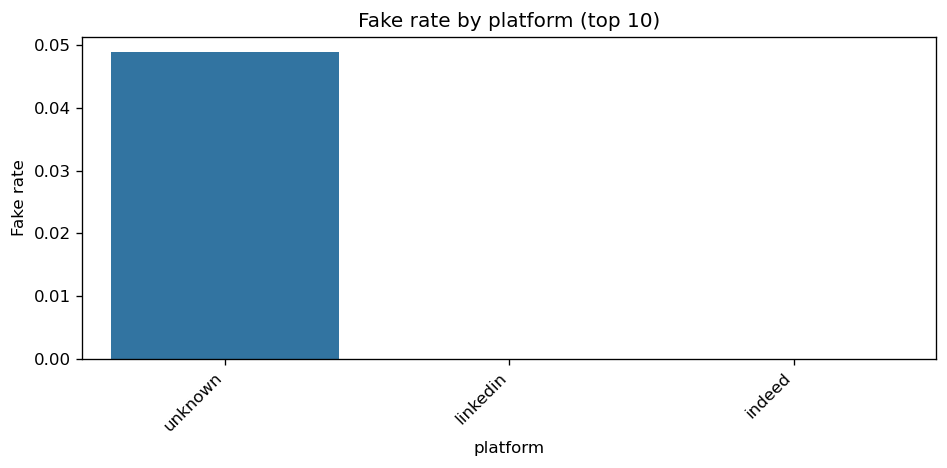

In [53]:
plt.figure(figsize=(8,4))
sns.barplot(x=plat.head(10).index, y=plat.head(10)['fake_rate'])
plt.title('Fake rate by platform (top 10)')
plt.ylabel('Fake rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'fake_rate_by_platform.png'), bbox_inches='tight')
plt.show()
plt.close()

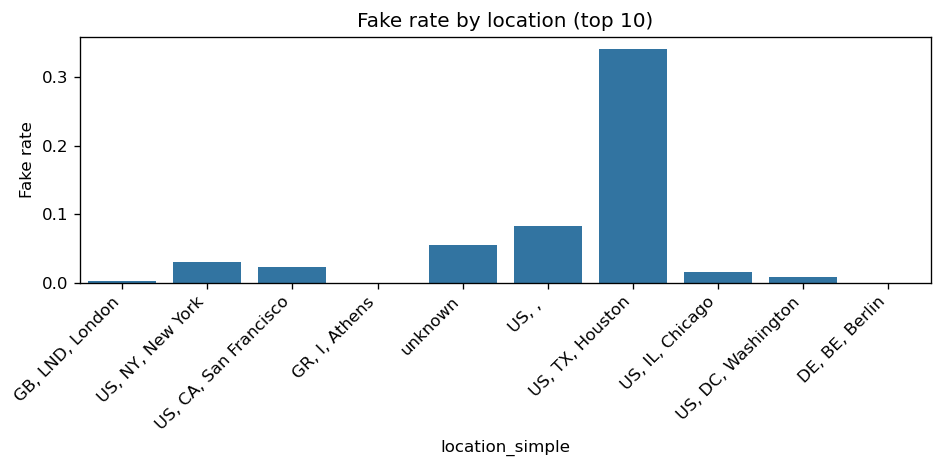

In [54]:
plt.figure(figsize=(8,4))
sns.barplot(x=loc.head(10).index, y=loc.head(10)['fake_rate'])
plt.title('Fake rate by location (top 10)')
plt.ylabel('Fake rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'fake_rate_by_location.png'), bbox_inches='tight')
plt.show()
plt.close()

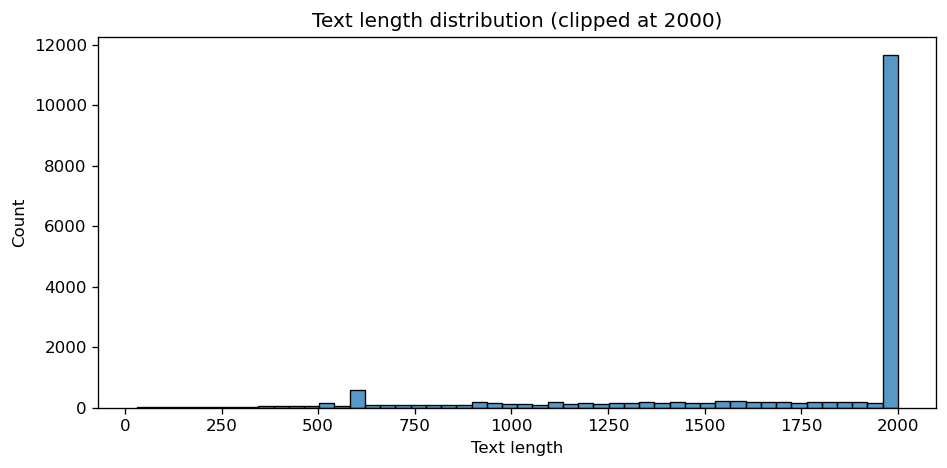

In [56]:
plt.figure(figsize=(8,4))
sns.histplot(df['text_len'].clip(upper=2000), bins=50)
plt.title('Text length distribution (clipped at 2000)')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR,'text_length_hist.png'), bbox_inches='tight')
plt.show()
plt.close()

<Figure size 1200x600 with 0 Axes>

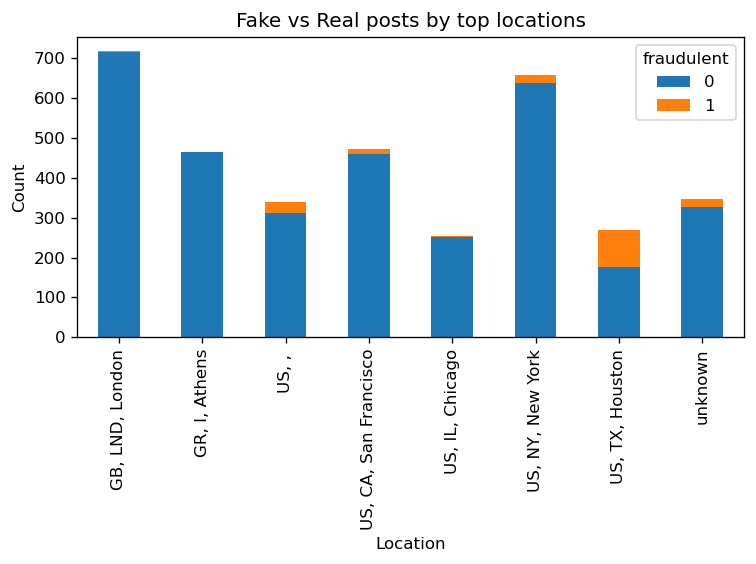

In [57]:
top_locs = loc.head(8).index.tolist()
sub = df[df['location_simple'].isin(top_locs)]
if not sub.empty:
    counts = sub.groupby(['location_simple', label_col]).size().unstack(fill_value=0)
    plt.figure(figsize=(10,5))
    counts.plot(kind='bar', stacked=True)
    plt.title('Fake vs Real posts by top locations')
    plt.xlabel('Location')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR,'fake_real_by_location_stacked.png'), bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
df_ml = df[df['text'].str.strip()!=''].copy()
X = df_ml['text']
y = df_ml[label_col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_SEED))
])

print("Training model...")
pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)
probs = pipe.predict_proba(X_test)[:,1]

print("\nClassification report:")
print(classification_report(y_test, preds, digits=4))
print("ROC AUC:", roc_auc_score(y_test, probs))


Training model...


In [36]:
preds = pipe.predict(X_test['text'])
probs = pipe.predict_proba(X_test['text'])[:,1]
print('
Classification report:')
print(classification_report(y_test, preds, digits=4))
print('ROC AUC:', roc_auc_score(y_test, probs))


cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.savefig(os.path.join(OUTPUT_DIR,'confusion_simple.png'), bbox_inches='tight')
plt.close()

SyntaxError: unterminated string literal (detected at line 3) (40607091.py, line 3)